In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'
password = '012500'
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
query_schema = 'set search_path to ' + schema_name + ';'

Only for SEPSIS

Table created in database

In [2]:
patient_sepsis_complete_query = '''
WITH patient_icu_age AS (
  SELECT
    i.subject_id,
    i.hadm_id,
    i.icustay_id,
    p.gender,
    ROUND(EXTRACT(DAY FROM i.intime - p.dob) / 365.25, 2) AS age_inICU_year,  -- Using 365.25 to account for leap years
    (EXTRACT(DAY FROM i.intime - p.dob) * 1440) + 
    (EXTRACT(HOUR FROM i.intime - p.dob) * 60) + 
    EXTRACT(MINUTE FROM i.intime - p.dob) AS age_inICU_min,
    i.intime,
    i.los as icu_duration_hour,
    p.expire_flag
  FROM
    mimiciii.icustays i
    LEFT JOIN mimiciii.patients p ON i.subject_id = p.subject_id
),

patient_icu_personal_info_withoutICUTimesTotal AS (
  SELECT
    pa.subject_id,
    pa.hadm_id,
    pa.icustay_id,
    pa.gender,
    pa.age_inICU_year,
    pa.age_inICU_min,
    a.INSURANCE,
    a.RELIGION,
    a.MARITAL_STATUS,
    a.ETHNICITY,
    a.DIAGNOSIS,
    a.DISCHTIME,
    a.DEATHTIME,
    pa.intime,
    RANK() OVER (PARTITION BY pa.subject_id ORDER BY pa.intime) AS icu_times,
    pa.icu_duration_hour,
    a.HOSPITAL_EXPIRE_FLAG,
    pa.expire_flag,
    CASE 
      WHEN a.deathtime is null or EXTRACT(DAY FROM a.deathtime - a.dischtime) > 1 THEN 0
      ELSE 1
    END AS died_immediately
  FROM
    patient_icu_age pa
    LEFT JOIN mimiciii.admissions a ON pa.hadm_id = a.hadm_id 
),

patient_icu_personal_info_all as (
  SELECT *, max(icu_times) over (partition by subject_id) as icu_times_total
  FROM patient_icu_personal_info_withoutICUTimesTotal
),

medTestRec as (
        select 
        c.SUBJECT_ID,
        c.HADM_ID,
        c.ICUSTAY_ID,
        c.ITEMID,
        di.label,
        c.CHARTTIME,
        c.VALUE

        from mimiciii.chartevents c left join mimiciii.d_items di 
        on c.ITEMID = di.ITEMID
        where c.stopped = 'NotStopd'
    ),
    
    outputRec as (
        select 
        o.SUBJECT_ID,
        o.HADM_ID,
        o.ICUSTAY_ID,
        o.ITEMID,
        di.label,
        o.CHARTTIME,
        cast (o.VALUE as character varying) as value
    
        from mimiciii.outputevents o left join mimiciii.d_items di 
        on o.ITEMID = di.ITEMID
    ),
    
    allTestRec as (
        select subject_id, hadm_id, icustay_id, itemid, label, charttime, value 
        from medTestRec
        union
        select subject_id, hadm_id, icustay_id, itemid, label, charttime, value 
        from outputRec),
    
    patient_complete as (
      SELECT
      pi.subject_id,
      pi.hadm_id,
      pi.icustay_id,
      pi.age_inICU_year,
      pi.age_inICU_min,
      pi.INSURANCE,
      pi.gender,
      pi.RELIGION,
      pi.MARITAL_STATUS,
      pi.ETHNICITY,
      pi.DIAGNOSIS,
      pi.DISCHTIME,
      pi.DEATHTIME,
      pi.icu_duration_hour,
      at.itemid,
      at.label as test_label,
      at.charttime as test_time,
      pi.intime,
      pi.icu_times,
      pi.icu_times_total,
      
      extract(day from at.charttime - pi.intime) * 24 +
      extract(hour from at.charttime - pi.intime) as test_time_from_inICU_hour,
      
      extract(day from at.charttime - pi.intime) * 24 * 60 +
      extract(hour from at.charttime - pi.intime) * 60 +
      extract(min from at.charttime - pi.intime) as test_time_from_inICU_min, 
      at.value as test_value,
      
      pi.HOSPITAL_EXPIRE_FLAG,
      pi.expire_flag,
      pi.died_immediately
            
      from allTestRec at 
      left join
      patient_icu_personal_info_all pi
      on at.icustay_id = pi.icustay_id
    )
    
    select * from patient_complete
    where diagnosis ~* 'sepsis'
    
    
    

'''

patient_sepsis_complete = pd.read_sql_query(patient_sepsis_complete_query, con)
##patient_sepsis_complete.to_csv(r'F:\STUDY\python_code\Pract_DA\prepocess\patient_sepsis_complete.csv')
patient_sepsis_complete

Glucose

In [3]:
glucose_query = '''
SELECT DISTINCT subject_id,
				icustay_id,				
                MIN(CAST(test_value AS FLOAT)) AS glu_min,
                MAX(CAST(test_value AS FLOAT)) AS glu_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS glu_avg
FROM mimiciii_generate.patient_sepsis_incomplete
WHERE test_label = 'Glucose'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label;
'''

glucose = pd.read_sql_query(glucose_query, con)
glucose

,subject_id,icustay_id,glu_min,glu_max,glu_avg
0,21,216859,102.0,349.0,187.00
1,33,296681,92.0,136.0,114.33
2,38,248910,84.0,230.0,115.92
3,62,216609,90.0,197.0,146.43
4,94,229012,153.0,182.0,166.33
...,...,...,...,...,...
953,32723,257461,85.0,158.0,121.50
954,32746,275952,101.0,178.0,139.50
955,32775,247825,83.0,107.0,95.00
956,32775,292368,54.0,202.0,120.45


All test

In [ ]:
complete_test_query = '''
-- glucose
with  all_glu as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                MIN(CAST(test_value AS FLOAT)) AS min_,
                MAX(CAST(test_value AS FLOAT)) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Glucose'
and test_label != 'Fingerstick Glucose'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),

glucose as(
    select subject_id,
		icustay_id,	
		MIN(cast(min_ as float)) as glu_min,
		MAX(cast(max_ as float)) as glu_max,
		round(cast(avg(avg_) as numeric), 2) as glu_avg
		from all_glu
		group by subject_id, icustay_id
),


-- finger glucose
figglucose as (
    SELECT DISTINCT subject_id,
				icustay_id,				
                MIN(CAST(test_value AS FLOAT)) AS figglu_min,
                MAX(CAST(test_value AS FLOAT)) AS figglu_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS figglu_avg
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label = 'Fingerstick Glucose'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id
),


-- potassium
all_potassium as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                MIN(CAST(test_value AS FLOAT)) AS min_,
                MAX(CAST(test_value AS FLOAT)) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Potassium'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),

potassium as (
    select subject_id,
		icustay_id,	
		MIN(cast(min_ as float)) as pot_min,
		MAX(cast(max_ as float)) as pot_max,
		round(cast(avg(avg_) as numeric), 2) as pot_avg
		from all_potassium
		group by subject_id, icustay_id
),
  

-- sodium
all_sodium as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                MIN(CAST(test_value AS FLOAT)) AS min_,
                MAX(CAST(test_value AS FLOAT)) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'sodium'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

sodium as (
    select subject_id,
		icustay_id,	
		MIN(cast(min_ as float)) as sod_min,
		MAX(cast(max_ as float)) as sod_max,
		round(cast(avg(avg_) as numeric), 2) as sod_avg
		from all_sodium
		group by subject_id, icustay_id
),


-- Hematocrit
all_hema as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Hematocrit'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

hema as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS hem_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS hem_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS hem_avg
		from all_hema
		group by subject_id, icustay_id
),


-- Chloride
all_chlo as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Chloride'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

chlo as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS chl_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS chl_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS chl_avg
		from all_chlo
		group by subject_id, icustay_id
  ),
  

-- BUN
all_bun as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'bun'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

bun as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS bun_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS bun_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS bun_avg
		from all_bun
		group by subject_id, icustay_id
  ),
  

-- Creatinine
all_crea as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Creatinine'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

crea as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS cre_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS cre_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS cre_avg
		from all_crea
		group by subject_id, icustay_id
  ),
  

-- Hemoglobin
hemo as (
    SELECT DISTINCT subject_id,
				icustay_id,	
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS hemo_min,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS hemo_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC),2) AS hemo_avg
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Hemoglobin'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),

-- Carbon dioxide
carb as (
    SELECT DISTINCT subject_id,
				icustay_id,	
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS car_min,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS car_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC),2) AS car_avg
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Carbon Dioxide'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),


-- RBC
all_rbc as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'RBC'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

rbc as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS rbc_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS rbc_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS rbc_avg
		from all_rbc
		group by subject_id, icustay_id
  ),
  

-- Platelets
all_plat as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Platelets'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

pla as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS pla_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS pla_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS pla_avg
		from all_plat
		group by subject_id, icustay_id
  ),
  

-- WBC
all_wbc as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'wbc'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

wbc as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS wbc_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS wbc_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS wbc_avg
		from all_wbc
		group by subject_id, icustay_id
  ),
  
  
-- heart rate
hea as (
    SELECT DISTINCT subject_id,
				icustay_id,	
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS hea_min,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS hea_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC),2) AS hea_avg
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'heart rate'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),


-- heart rhythm
frequency AS (
    SELECT 
        subject_id,
        icustay_id,
        test_label,
        test_value,
        COUNT(*) AS freq
    FROM 
        mimiciii_generate.patient_sepsis_complete
    WHERE 
        test_label ~* 'heart rhythm' AND
        subject_id IS NOT NULL
    GROUP BY 
        subject_id, icustay_id, test_label, test_value
),
max_frequency AS (
    SELECT 
        subject_id,
        icustay_id,
        test_label,
        MAX(freq) AS max_freq
    FROM 
        frequency
    GROUP BY 
        subject_id, icustay_id, test_label
),
mode_value AS (
    SELECT 
        f.subject_id,
        f.icustay_id,
        f.test_label,
        f.test_value AS mode_value
    FROM 
        frequency f
    JOIN 
        max_frequency mf ON f.subject_id = mf.subject_id 
        AND f.icustay_id = mf.icustay_id 
        AND f.test_label = mf.test_label 
        AND f.freq = mf.max_freq
),
last_value AS (
    SELECT 
        subject_id,
        icustay_id,
        test_label,
        test_value AS last_test_value,
        ROW_NUMBER() OVER (PARTITION BY subject_id, icustay_id, test_label ORDER BY test_time DESC) AS rn
    FROM 
        mimiciii_generate.patient_sepsis_complete
    WHERE 
        test_label ~* 'heart rhythm' AND
        subject_id IS NOT NULL
),

heaRhy as (SELECT 
    lv.subject_id,
    lv.icustay_id,
    mv.mode_value as heaR_mode,
    lv.last_test_value as heaR_last
FROM 
    last_value lv
JOIN 
    mode_value mv ON lv.subject_id = mv.subject_id 
    AND lv.icustay_id = mv.icustay_id 
    AND lv.test_label = mv.test_label
WHERE 
    lv.rn = 1
),


-- Magnesium
all_mag as (SELECT DISTINCT subject_id,
				icustay_id,	
				test_label,
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS min_,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS max_,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS avg_
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Magnesium'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label),

mag as (
    select subject_id,
		icustay_id,	
		ROUND(CAST(MIN(CAST(min_ AS FLOAT)) AS NUMERIC), 2) AS mag_min,
        ROUND(CAST(MAX(CAST(max_ AS FLOAT)) AS NUMERIC), 2) AS mag_max,
        ROUND(CAST(AVG(CAST(avg_ AS FLOAT)) AS NUMERIC), 2) AS mag_avg
		from all_mag
		group by subject_id, icustay_id
  ),
  

-- Respiratory Rate
res as (
    SELECT DISTINCT subject_id,
				icustay_id,	
                round(cast(MIN(CAST(test_value AS FLOAT)) as numeric),2) AS res_min,
                round(cast(MAX(CAST(test_value AS FLOAT)) as numeric),2) AS res_max,
                round(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC),2) AS res_avg
FROM mimiciii_generate.patient_sepsis_complete
WHERE test_label ~* 'Respiratory Rate'
and not test_label ~* 'Respiratory Rate Set'
and test_value ~ '^\d+(\.\d+)?$'
and subject_id is not null
GROUP BY subject_id, icustay_id, test_label
),


--SpO2
spo as (
    SELECT DISTINCT 
    subject_id,
    icustay_id,  
    ROUND(CAST(MIN(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS spo_min,
    ROUND(CAST(MAX(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS spo_max,
    ROUND(CAST(AVG(CAST(test_value AS FLOAT)) AS NUMERIC), 2) AS spo_avg,
    COUNT(CASE WHEN CAST(test_value AS FLOAT) < 90 THEN 1 ELSE NULL END) AS spo_alarms
FROM 
    mimiciii_generate.patient_sepsis_complete
WHERE 
    test_label = 'SpO2'  
    AND test_value ~ '^\d+(\.\d+)?$'  
    AND subject_id IS NOT NULL 
GROUP BY 
    subject_id, icustay_id, test_label
),


-- temperature F
TemperatureData AS (
    SELECT 
        subject_id,
        icustay_id,
        CASE
            WHEN test_label = 'Temperature C' THEN CAST(test_value AS FLOAT) * 9 / 5 + 32
            ELSE CAST(test_value AS FLOAT)
        END AS temp_f
    FROM 
        mimiciii_generate.patient_sepsis_complete
    WHERE 
        (test_label = 'Temperature F' OR test_label = 'Temperature C')
        AND test_value ~ '^\d+(\.\d+)?$'  -- Ensures test_value is numeric
        AND subject_id IS NOT NULL
),

temp as (SELECT 
    subject_id,
    icustay_id,  
    ROUND(CAST(MIN(temp_f) AS NUMERIC), 2) AS temp_min,
    ROUND(CAST(MAX(temp_f) AS NUMERIC), 2) AS temp_max,
    ROUND(CAST(AVG(temp_f) AS NUMERIC), 2) AS temp_avg
FROM 
    TemperatureData
GROUP BY 
    subject_id, icustay_id
)


-- basic info

select distinct
bi.subject_id,
bi.icustay_id,
bi.age_inicu_year as age,
bi.gender,
bi.marital_status,
bi.ethnicity,
bi.icu_duration_hour,
bi.icu_times,
bi.icu_times_total,
bi.icu_times_sepsis,
bi.icu_times_total_sepsis,

glu.glu_min,
glu.glu_max,
glu.glu_avg,

fg.figglu_min,
fg.figglu_max,
fg.figglu_avg,

pot.pot_min,
pot.pot_max,
pot.pot_avg,

sod.sod_min,
sod.sod_max,
sod.sod_avg,

hem.hem_min,
hem.hem_max,
hem.hem_avg,

chl.chl_min,
chl.chl_max,
chl.chl_avg,

bun.bun_min,
bun.bun_max,
bun.bun_avg,

cre.cre_min,
cre.cre_max,
cre.cre_avg,

hemo.hemo_min,
hemo.hemo_max,
hemo.hemo_avg,

car.car_min,
car.car_max,
car.car_avg,

rbc.rbc_min,
rbc.rbc_max,
rbc.rbc_avg,

pla.pla_min,
pla.pla_max,
pla.pla_avg,

wbc.wbc_min,
wbc.wbc_max,
wbc.wbc_avg,

hea.hea_min,
hea.hea_max,
hea.hea_avg,

heaR.heaR_mode,
heaR.heaR_last,

mag.mag_min,
mag.mag_max,
mag.mag_avg,

res.res_min,
res.res_max,
res.res_avg,

spo.spo_min,
spo.spo_max,
spo.spo_avg,
spo.spo_alarms,

temp.temp_min,
temp.temp_max,
temp.temp_avg,


bi.HOSPITAL_EXPIRE_FLAG,
bi.expire_flag,
bi.died_immediately

from 
mimiciii_generate.patient_sepsis_complete bi
left join 
glucose glu on bi.icustay_id = glu.icustay_id
left join 
figglucose fg on bi.icustay_id = fg.icustay_id
left join
potassium pot on bi.icustay_id = pot.icustay_id
left join
sodium sod on bi.icustay_id = sod.icustay_id
left join
hema hem on bi.icustay_id = hem.icustay_id
left join
chlo chl on bi.icustay_id = chl.icustay_id
left join
bun on bi.icustay_id = bun.icustay_id
left join
crea cre on bi.icustay_id = cre.icustay_id
left join
hemo on bi.icustay_id = hemo.icustay_id
left join
carb car on bi.icustay_id = car.icustay_id
left join
rbc on bi.icustay_id = rbc.icustay_id
left join
pla on bi.icustay_id = pla.icustay_id
left join 
wbc on bi.icustay_id = wbc.icustay_id
left join
hea on bi.icustay_id = hea.icustay_id
left join
heaRhy heaR on bi.icustay_id = heaR.icustay_id
left join
mag on bi.icustay_id = mag.icustay_id
left join
res on bi.icustay_id = res.icustay_id
left join
spo on bi.icustay_id = spo.icustay_id
left join
temp on bi.icustay_id = temp.icustay_id


'''



Drop duplicate

Since the mode of heart rhythm might not be a unique value if two or more values have the same amount.
We decided to delete all of them completely. Only 10 patients/20 records will be removed, which might not affect the dataset too much. Also, only one of the duplicated records ends up died. If we are doing an outlier detection, this also does not remove too much of the positive samples.

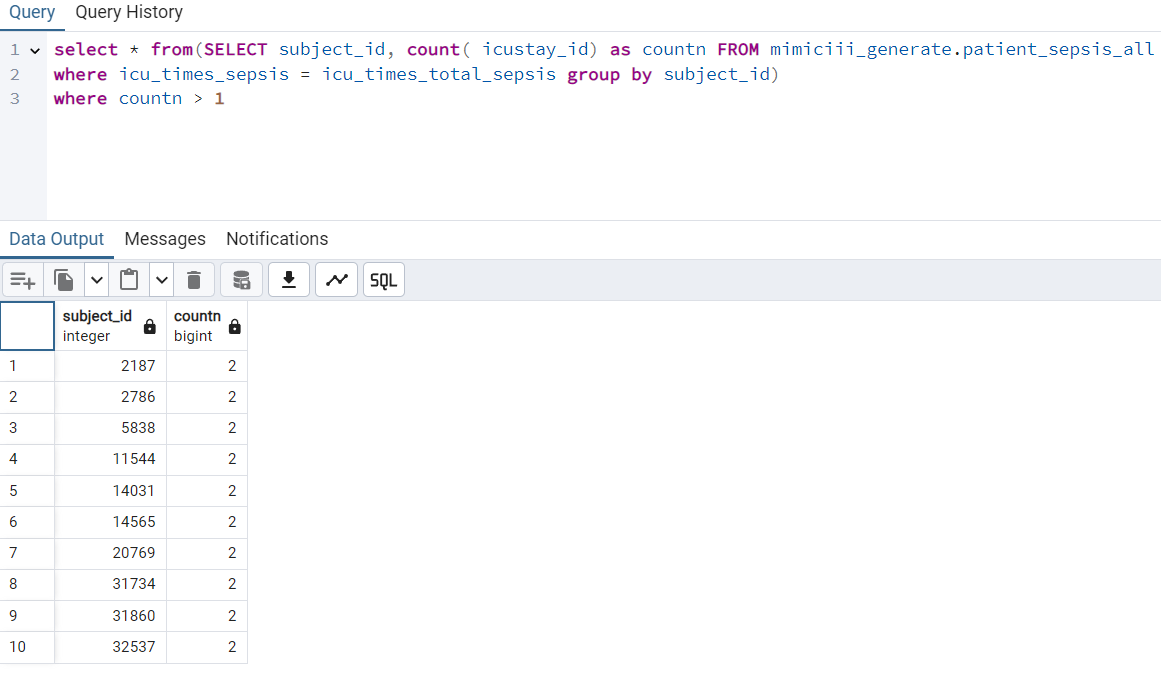

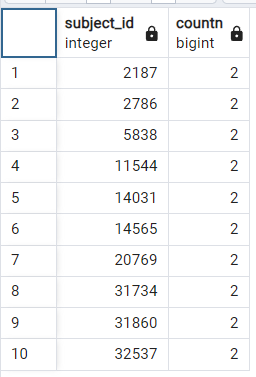

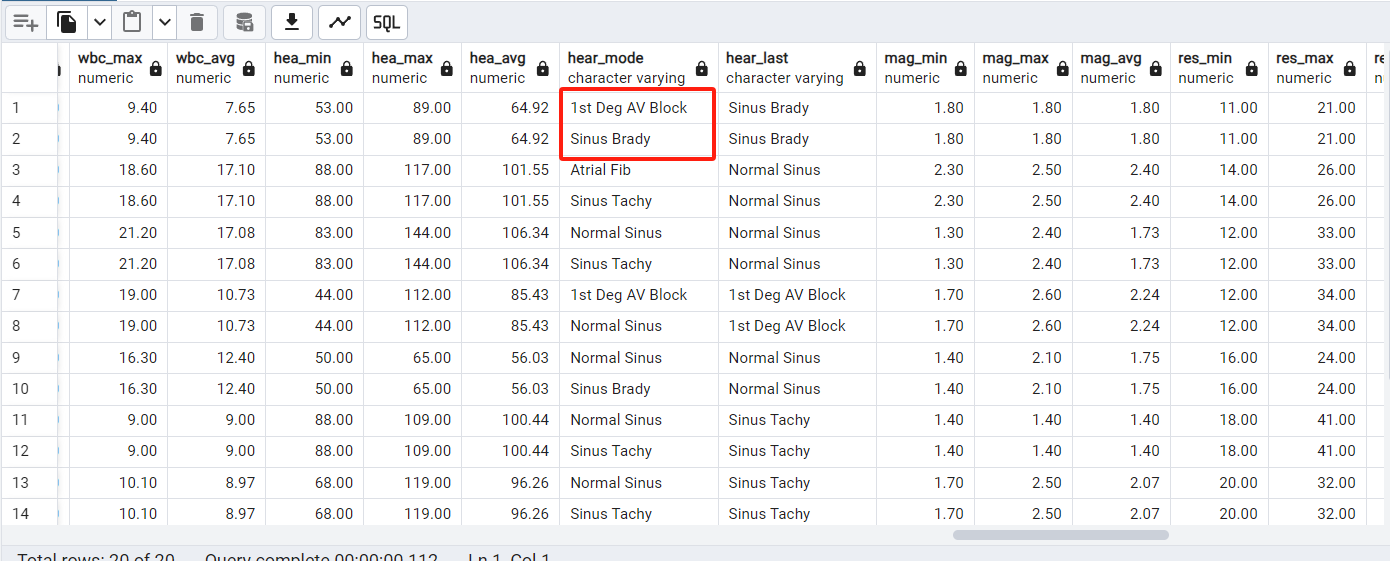